<a href="https://colab.research.google.com/github/roshankumarbhuyan/Customer-preference-Using-KNN/blob/master/Reply_TD_Google_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 <h1>What is the Scope of this Project? </h1>


 The Scope of this Project is to collect data from **Google Maps Places API**.

The following place requests are available on the [Places API](https://developers.google.com/maps/documentation/places/web-service/search):
*   Place Search returns a list of places based on a user's location or search string.
*   Place Details returns more detailed information about a specific place, including user reviews.
*   Place Photos provides access to the millions of place-related photos stored in Google's Place database.
*   Place Autocomplete automatically fills in the name and/or address of a place as users type.
*   Query Autocomplete provides a query prediction service for text-based geographic searches, returning suggested queries as users type.

The Scope of the Project would be only limited to Place Search.
This API was choosen because information about places are returned using HTTP requests. 

<h2> Pricing for the Places API</h2>
Under the pay-as-you-go pricing model, requests for the Places API are billed by SKU.The Basic Data SKU is free of costs and is triggered when any of these fields are requested: 

*   address_component 
*   adr_address 
*   **business_status**
*   **formatted_address**
*   **geometry**(latitude and longitude)
*   icon
*   **name**
*   permanently_closed
*   photo
*   place_id
*   plus_code
*   Type
*   url
*   utc_offset
*   vicinity

For the Sake of Simplicity and keeping usage within the Free tier, Only the highlighted fields would be requested.

An API key is necessary and can be generated from the Google Cloud Console

In [ ]:
Fields = ['business_status','formatted_address','name','geometry','rating','types']
google_api_key = ''
path_to_input = 'INPUT_CATEGORICAL_SAMPLE.csv'

<h1>Approach and steps</h1>

A random point with a Lat and Long would be selected and a text Query would be sent to the Places API to see the Results.  <br>  
For Example:
The lat and long for the center of Berlin  <br>
52.5200° N, 13.4050° E <br>
would be sent and Google would be asked for "Doner" results in a 2 km radius.

This would be a Sample Test.  <br>
Later This would be automated so that such points and queries can be passed in Bulk to the API.


In [ ]:
import requests
import csv
import json
import geopy.distance
import time
import pandas as pd
import numpy
import ast 
from math import sin, cos, sqrt, atan2, radians


The Sample Call

In [ ]:
#adding parameters for sample test
Search_Radius = '2000'
query = 'Doner'
input_lat = '52.520008'
input_long = '13.404954'

In [ ]:
Queryfields = "fields=" + ','.join(Fields)
google_api_request = 'https://maps.googleapis.com/maps/api/place/textsearch/json?query=' + query + '&location=' + input_lat + ',' + input_long +'&'+ Queryfields+ '&radius=' +Search_Radius+ '&key=' + google_api_key
google_result = requests.get(google_api_request)
assert len(json.loads(google_result.text)['results']) != 0, "Failed to Connect to API as API sent 0 Results. Please Check your key"

A Sample of the Result from the API.
The results are in JSON format and Need to be converted to a Tabular Format for further use
```
{
         "business_status" : "OPERATIONAL",
         "formatted_address" : "Alexanderpl. 8, 10178 Berlin, Germany",
         "geometry" : {
            "location" : {
               "lat" : 52.522989,
               "lng" : 13.4119667
            },
            "viewport" : {
               "northeast" : {
                  "lat" : 52.52437497989273,
                  "lng" : 13.41287027989272
               },
               "southwest" : {
                  "lat" : 52.52167532010728,
                  "lng" : 13.41017062010728
               }
            }
         },
```

In [ ]:
#Function to convert JSON to DF
def return_df_from_JSON(google_result,lat,longi,query):
   try:
     google_result_items = json.loads(google_result.text)['results']
     df = pd.DataFrame.from_dict(google_result_items)
     df['Provider'] = 'GOOGLE'
     df['Input_Lat'] = lat
     df['Input_Long'] = longi
     df['POI_Input'] = query
   except:
     d = {'Provider':'GOOGLE','Input_Lat':lat,'Input_Long':longi,'POI_Input':query } 
     df = pd.DataFrame(d, index=[0])
   return df

In [ ]:
df = return_df_from_JSON(google_result,input_lat,input_long,query)
print('Total results returned = %d'  %len(df) )
display(df)

By default, each Nearby Search or Text Search returns up to 20 establishment results per query.

However, each search can return as many as 60 results, split across three pages.

We need to Pass the value of the next_page_token to the pagetoken parameter of a new search to see the next set of results. 

If the next_page_token is null, or is not returned, then there are no further results. 

<H3> The results contain Free text and Json and do not contain the distance from point of search </H3>
A class and a few functions need to be written to provide us with formatted tabular output

In [ ]:
def get_distance(lat1,lon1,lat2,lon2):
    # approximate radius of earth in km
  R = 6373.0
  lat1 = radians(float(lat1))
  lon1 = radians(float(lon1))
  lat2 = radians(float(lat2))
  lon2 = radians(float(lon2))
  dlon = lon2 - lon1
  dlat = lat2 - lat1
  a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
  c = 2 * atan2(sqrt(a), sqrt(1 - a))
  distance = R * c *1000
  return distance   

def return_tabular_output(df):
  log_col = ['Provider','Input_Lat','Input_Long','POI_Input']
  log_col.extend(Fields)
  df = df[log_col]
  df['lat_position']= df['geometry'].apply(lambda x: x['location']['lat'])
  df['lon_position']= df['geometry'].apply(lambda x: x['location']['lat'])
  df['type']= df['types'].apply(lambda x: x[0])
  df["Distance"] = df[["Input_Lat", "Input_Long", "lat_position",'lon_position']].apply(lambda x : get_distance(*x), axis=1)
  return df

<h1> Sample Test Ends Here. Bulk API call Programming Begin here<h4>

An input file with the following format need to be created

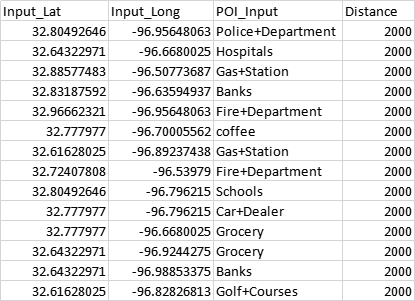

We Create a function to query the API and return us with a dataframe with the help of return_df_from_JSON function

In [ ]:
def return_data_from_input(row):
  input_lat = row[0]
  input_long = row[1]
  input_distance = row[3]
  query = row[2]
  Queryfields = "fields=" + ','.join(Fields)
  google_api_request = 'https://maps.googleapis.com/maps/api/place/textsearch/json?query=' + query + '&location=' + input_lat + ',' + input_long +'&'+ Queryfields+ '&radius=' +Search_Radius+ '&key=' + google_api_key
  print(google_api_request,input_lat,input_long,query)
  google_result = requests.get(google_api_request)
  df = return_df_from_JSON(google_result,input_lat,input_long,query)
  try:
    if json.loads(google_result.text)['next_page_token']:
      time.sleep(2)
      google_api_request_page2 = google_api_request + '&pagetoken=' + json.loads(google_result.text)['next_page_token']
      google_page2_result = requests.get(google_api_request_page2)
      df2 = return_df_from_JSON(google_page2_result,input_lat,input_long,query)
      df = df.append(df2)
      try:
        if json.loads(google_page2_result.text)['next_page_token']:
          time.sleep(2)
          google_api_request_page3 = google_api_request + '&pagetoken=' + json.loads(google_page2_result.text)['next_page_token']
          google_page3_result = requests.get(google_api_request_page3)
          df3 = return_df_from_JSON(google_page3_result,input_lat,input_long,query)
          df = df.append(df3)
          try:
            if str(json.loads(google_page3_result.text)['next_page_token']):
              time.sleep(2)
              google_api_request_page4 = google_api_request + '&pagetoken=' + json.loads(google_page3_result.text)['next_page_token']
              google_page4_result = requests.get(google_api_request_page4)
              df4 = return_df_from_JSON(google_page4_result,input_lat,input_long,query)
              df = df.append(df4)
          except:pass
      except:pass
  except:pass

  return df

In [ ]:
DF =   pd.DataFrame()
with open('INPUT_CATEGORICAL_SAMPLE.csv', encoding="utf8", errors='ignore') as csvfile:
  readCSV = csv.reader(csvfile, delimiter=',')
  list_of_rows = list(readCSV)
  for rows in range(1,len(list_of_rows),1):
    print('Call number: ' + str(rows))
    print(list_of_rows[rows])
    df = return_tabular_output(return_data_from_input(list_of_rows[rows]))
    DF = DF.append(df2)
    DF.to_csv('OUTPUT_Google_CATEGORICAL.csv', mode='a', header=True)
  print("ALL JOBS COMPLETE")